## **Deepfake Detection with a Convolutional Neural Network**
Daniel Radunsky, Adam Torres Encarnacion

#### **Import Packages**

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np

#### **Unzip Files (Only if Needed, Works Faster than Windows)**

In [ ]:
import zipfile
from pathlib import Path
from tqdm import tqdm

def unzip_file(zip_path, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get a list of all the files in the zip archive
        files = zip_ref.namelist()
        
        # Show progress bar while extracting
        for file in tqdm(files, desc="Unzipping", unit="file"):
            zip_ref.extract(file, output_dir)

# Path to the zip file
zip_path = Path(r"c:\Users\kingd\Downloads\Dataset.zip")
# Directory to extract to
output_dir = Path("./data")

# Unzip the file
unzip_file(zip_path, output_dir)

#### **Load Data**

In [ ]:
train_dir = './data/Train'
test_dir = './data/Test'

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # RESIZE TO 128X128
    transforms.ToTensor(),  # MAKE THE IMAGES TENSORS
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # NORMALIZE PICTURES
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

real_class_idx = train_dataset.class_to_idx['Real']
fake_class_idx = train_dataset.class_to_idx['Fake']

real_train_indices = [i for i, target in enumerate(train_dataset.targets) if target == real_class_idx]
fake_train_indices = [i for i, target in enumerate(train_dataset.targets) if target == fake_class_idx]
train_indices = real_train_indices[:20000] + fake_train_indices[:20000]

real_test_indices = [i for i, target in enumerate(test_dataset.targets) if target == real_class_idx]
fake_test_indices = [i for i, target in enumerate(test_dataset.targets) if target == fake_class_idx]
test_indices = real_test_indices[:5000] + fake_test_indices[:5000]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# LOAD IN TRAIN/TEST DATA
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

#### **Architecture**

In [ ]:
class Detector(nn.Module):
    def __init__(self):
        super(Detector, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1),  # CONVOLUTIONAL LAYER 1 (3 KERNEL SIZE , 1 STRIDE)
            nn.ReLU(), # RELU ACTIVATION FOR LAYER 1
            nn.Conv2d(16, 4, 1), # CONVOLUTIONAL LAYER 2
            nn.ReLU(), # RELU ACTIVATION FOR LAYER 2
            nn.BatchNorm2d(4), # NORMALIZE VALUES (4 FEATURES)
            nn.MaxPool2d(8, 8) # MAX POOLING (8 KERNEL SIZE, 8 STRIDE)
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5), # HELPS WITH OVERFITTING
            nn.Linear(4 * 15 * 15, 1),
            nn.Sigmoid()  # NORMALIZE TO [0,1] RANGE
        )

    def forward(self, x): # FEEDFORWARD PHASE
        x = self.features(x)
        x = self.classifier(x)
        return x

#### **GPU Optimization**

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # OPTIMIZE TO GPU
print(device)
model = Detector().to(device)

cuda


#### **Calculate Accuracy**

In [152]:
criterion = nn.BCELoss() # BINARY CROSS ENTROPY LOSS (BINARY CLASSIFICATION FOR REAL/FAKE)
optimizer = optim.Adam(model.parameters(), lr=1e-5) # LOW LR ADAM OPTIMIZER

def calculate_accuracy(outputs, labels): 
    predicted = (outputs > 0.5).float() # VALUES CLOSER TO 0 ARE FAKE, CLOSER TO 1 ARE REAL
    correct = (predicted == labels).sum().item() 
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


#### **Training/Testing Loop**

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10
for epoch in range(num_epochs): # 10 EPOCHS
    model.train() # TRAINING LOOP
    current_loss = 0.0
    running_corrects = 0

    
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad() # SET GRADIENTS TO ZERO

        outputs = model(images) 
        loss = criterion(outputs.squeeze(), labels)

        loss.backward() # BACPROPAGATION
        optimizer.step()

        current_loss += loss.item() # CALCULATE LOSS VALUE THROUGHOUT TRAINING
        running_corrects += calculate_accuracy(outputs.squeeze(), labels)  

    
    train_loss = current_loss / len(train_loader) # TRAINING LOSS
    train_accuracy = running_corrects / len(train_loader) # TRAINING ACCURACY

   
    model.eval()
    current_loss = 0.0
    current_correct = 0
    total_samples = 0

    # TESTING LOOP
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            current_loss += loss.item() 
            current_correct += calculate_accuracy(outputs.squeeze(), labels) 
            total_samples += labels.size(0)
        
    test_loss = current_loss / len(test_loader)
    test_accuracy = current_correct / len(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    
    print(f"Epoch {epoch + 1}:")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {100 * test_accuracy:.2f}%")

Epoch 1:
Training Loss: 0.7501, Training Accuracy: 58.98%
Testing Loss: 0.8474, Testing Accuracy: 60.09%
Epoch 2:
Training Loss: 0.6525, Training Accuracy: 65.35%
Testing Loss: 0.6992, Testing Accuracy: 63.16%
Epoch 3:
Training Loss: 0.6078, Training Accuracy: 68.29%
Testing Loss: 0.5738, Testing Accuracy: 64.41%
Epoch 4:
Training Loss: 0.5860, Training Accuracy: 70.02%
Testing Loss: 0.4565, Testing Accuracy: 65.05%
Epoch 5:
Training Loss: 0.5672, Training Accuracy: 71.08%
Testing Loss: 0.6106, Testing Accuracy: 65.33%
Epoch 6:
Training Loss: 0.5559, Training Accuracy: 72.11%
Testing Loss: 0.5608, Testing Accuracy: 65.59%
Epoch 7:
Training Loss: 0.5460, Training Accuracy: 72.36%
Testing Loss: 0.6201, Testing Accuracy: 65.65%
Epoch 8:
Training Loss: 0.5364, Training Accuracy: 73.15%
Testing Loss: 0.4186, Testing Accuracy: 65.74%
Epoch 9:
Training Loss: 0.5274, Training Accuracy: 73.57%
Testing Loss: 0.3563, Testing Accuracy: 65.86%
Epoch 10:
Training Loss: 0.5280, Training Accuracy: 73.

In [154]:
print("Train Losses: ", train_losses)
print("Train Accuracies: ", train_accuracies)

print("Test Losses: ", test_losses)
print("Test Accuracies: ", test_accuracies)

Train Losses:  [0.7501204538345337, 0.6524912554502487, 0.6077843574523926, 0.5860142501115799, 0.5672439207792283, 0.5558877912998199, 0.5460333117723465, 0.5364417873859405, 0.5273904579162597, 0.5279581633090973]
Train Accuracies:  [0.58975, 0.65355, 0.68295, 0.70015, 0.7108, 0.72115, 0.72365, 0.7315, 0.735675, 0.73805]
Test Losses:  [0.8474481105804443, 0.6991885900497437, 0.5738389492034912, 0.45648545026779175, 0.610633134841919, 0.5608459711074829, 0.6200838088989258, 0.4186394214630127, 0.3563372492790222, 0.3453626036643982]
Test Accuracies:  [0.6009384984025559, 0.6315894568690096, 0.6440694888178914, 0.6504592651757188, 0.6532547923322684, 0.6558506389776357, 0.6565495207667732, 0.6574480830670927, 0.6586461661341853, 0.6605431309904153]


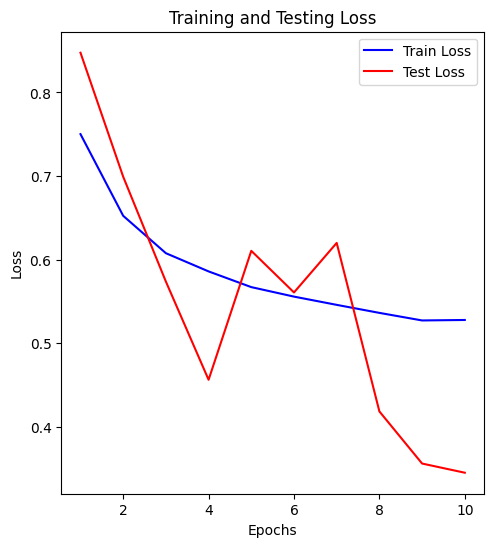

In [155]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

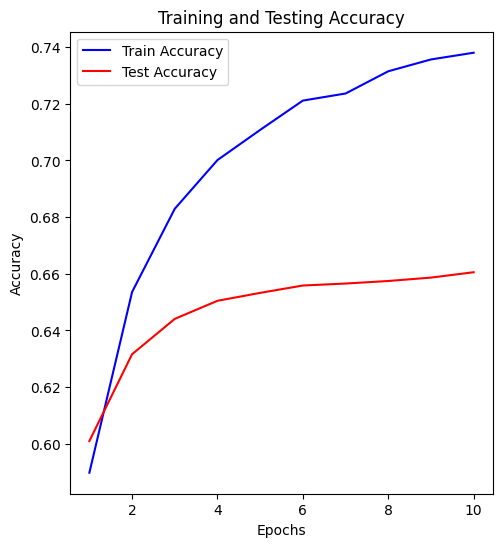

In [156]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()
